# Machine Learning and Artificial Intelligance <br>#Final Report

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

(36, 138, 3)


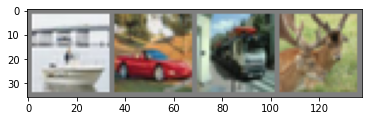

 ship   car truck  deer
torch.Size([3, 32, 32])


In [ ]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)

In [ ]:
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                         stride=stride, padding=1, bias=False) 
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                         stride=1, padding=1, bias=False) 
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.stride = stride
    
    if down_sample:
      self.down_sample = IdentityPadding(in_channels, out_channels, stride)
    else:
      self.down_sample = None


  def forward(self, x):
    shortcut = x

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)

    if self.down_sample is not None:
      shortcut = self.down_sample(x)

    out += shortcut
    out = self.relu(out)
    return out

In [ ]:
class InceptionBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, down_sample=False):
    super(InceptionBlock, self).__init__()
    self.relu = nn.ReLU(inplace=True)
    
    self.b1 = nn.Sequential(
      nn.Conv2d(in_channels, int(out_channels/4), kernel_size=1),
      nn.BatchNorm2d(int(out_channels/4)),
    )

    self.b2 = nn.Sequential(
      nn.Conv2d(in_channels, int(out_channels/4), kernel_size=1),
      nn.BatchNorm2d(int(out_channels/4)),
      nn.ReLU(True),
      nn.Conv2d(int(out_channels/4), int(out_channels/4), kernel_size=3, padding=1),
      nn.BatchNorm2d(int(out_channels/4)),
    )

    self.b3 = nn.Sequential(
      nn.Conv2d(in_channels, int(out_channels/4), kernel_size=1),
      nn.BatchNorm2d(int(out_channels/4)),
      nn.ReLU(True),
      nn.Conv2d(int(out_channels/4), int(out_channels/4), kernel_size=5, padding=2),
      nn.BatchNorm2d(int(out_channels/4)),
    )

    self.b4 = nn.Sequential(
      nn.MaxPool2d(3, stride=1, padding=1),
      nn.Conv2d(in_channels, int(out_channels/4), kernel_size=1),
      nn.BatchNorm2d(int(out_channels/4)),
    )
    self.bn2 = nn.BatchNorm2d(out_channels)

    if down_sample:
      self.down_sample = IdentityPadding(in_channels, out_channels, 1)
    else:
      self.down_sample = None

  def forward(self, x):
    shortcut = x

    y1 = self.b1(x)
    y2 = self.b2(x)
    y3 = self.b3(x)
    y4 = self.b4(x)
    out = torch.cat([y1,y2,y3,y4], 1)

    if self.down_sample is not None:
      shortcut = self.down_sample(x)
      
    out += shortcut
    out = self.relu(out)
    return out

In [ ]:
class IdentityPadding(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(IdentityPadding, self).__init__()

        self.pooling = nn.MaxPool2d(1, stride=stride)
        self.add_channels = out_channels - in_channels
    
    def forward(self, x):
        out = F.pad(x, (0, 0, 0, 0, 0, self.add_channels))
        out = self.pooling(out)
        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, num_layers, block, block2, num_classes=10):
      super(ResNet, self).__init__()
      self.num_layers = num_layers
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, 
							   stride=1, padding=1, bias=False)
      self.bn1 = nn.BatchNorm2d(16)
      self.relu = nn.ReLU(inplace=True)


      self.layers_2n = self.get_layers(block, 16, 16, stride=1)
      self.layers_4n = self.get_layers(block2, 16, 32, stride=2)
      self.layers_6n = self.get_layers(block, 32, 64, stride=2)

      self.avg_pool = nn.AvgPool2d(8, stride=1)
      self.fc_out = nn.Sequential( nn.Linear(5184, 1024),
                                  nn.Linear(1024, num_classes),
      )
		
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(m, nn.BatchNorm2d) :
          nn.init.constant_(m.weight, 1)
          nn.init.constant_(m.bias, 0)
	

    def get_layers(self, block, in_channels, out_channels, stride):
      if stride == 2:
        down_sample = True
      else:
        down_sample = False
		
      layers_list = nn.ModuleList(
        [block(in_channels, out_channels, stride, down_sample)])
      for _ in range(self.num_layers - 1):
        layers_list.append(block(out_channels, out_channels))

      return nn.Sequential(*layers_list)
		
    def forward(self, x):
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)

      x = self.layers_2n(x)
      x = self.layers_4n(x)
      x = self.layers_6n(x)

      x = self.avg_pool(x)
      x = x.view(x.size(0), -1)
      #print(x.shape)
      x = self.fc_out(x)
      return x

def resnet():
  block = ResidualBlock
  block2 = InceptionBlock
  model = ResNet(7, block, block2) 
  return model

In [ ]:
net = resnet()
net.cuda()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers_2n): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [ ]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [ ]:
# Define a Loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [ ]:
# function to calculate accuracy
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
      for data in dataloader:
        images, labels = data
        # Inference on GPU
        images = images.to(device)
        labels = labels.to(device)
    
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' % (total,
        100 * correct / total))

In [ ]:
# Function to train the network
train_loss = []
train_accu = []
xaxis = []

def train(net, trainloader, max_epoch, crit, opt, model_path='./cifar_net.pth'):

    for epoch in range(max_epoch):  # loop over the dataset multiple times
      correct = 0
      total = 0
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
    
        # Training on GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = crit(outputs, labels)
        loss.backward()

        opt.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
          train_loss.append(running_loss / 2000)
          train_accu.append(accuracy)
          x = (i+1)/2000/7+epoch+1
          xaxis.append(x)

          print('[%d, %5d] loss: %.3f  accuracy: %.3f' % (epoch + 1, i + 1, running_loss / 2000, accuracy))
          running_loss = 0.0
      print_accuracy(net, testloader)

    print('Finished Training')
    torch.save(net.state_dict(), model_path)
    print('Saved Trained Model')

In [ ]:
PATH = './cifar_net.pth'
train(net, trainloader, 11, criterion, optimizer, PATH)

[1,  2000] loss: 2.721  accuracy: 24.150
[1,  4000] loss: 1.766  accuracy: 29.875
[1,  6000] loss: 1.621  accuracy: 33.567
[1,  8000] loss: 1.522  accuracy: 36.234
[1, 10000] loss: 1.447  accuracy: 38.627
[1, 12000] loss: 1.372  accuracy: 40.583
Accuracy of the network on the 10000 test images: 53 %
[2,  2000] loss: 1.284  accuracy: 54.425
[2,  4000] loss: 1.223  accuracy: 55.000
[2,  6000] loss: 1.155  accuracy: 56.471
[2,  8000] loss: 1.134  accuracy: 57.353
[2, 10000] loss: 1.106  accuracy: 58.015
[2, 12000] loss: 1.061  accuracy: 58.700
Accuracy of the network on the 10000 test images: 62 %
[3,  2000] loss: 0.966  accuracy: 65.675
[3,  4000] loss: 0.956  accuracy: 66.006
[3,  6000] loss: 0.938  accuracy: 66.421
[3,  8000] loss: 0.895  accuracy: 66.844
[3, 10000] loss: 0.889  accuracy: 67.338
[3, 12000] loss: 0.874  accuracy: 67.623
Accuracy of the network on the 10000 test images: 70 %
[4,  2000] loss: 0.828  accuracy: 70.888
[4,  4000] loss: 0.795  accuracy: 71.688
[4,  6000] loss

Accuracy of the network on the 10000 test images: 80 %


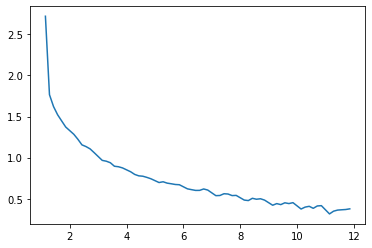

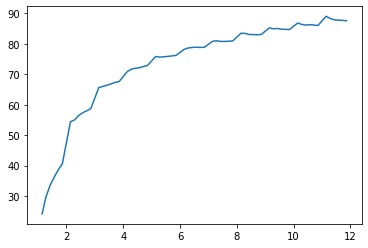

In [ ]:
from matplotlib import pyplot as plt
print_accuracy(net, testloader)

#loss그래프
plt.plot(xaxis,train_loss)
plt.show()

#accuracy그래프
plt.plot(xaxis,train_accu)
plt.show()